## Gradient methods

#### Problem:
$$
f(\vec{x}) \rightarrow min,\\
f: \Omega \rightarrow \mathbb{R}, \\
\Omega \subset \mathbb{R^n}, f(\vec{x}) \mbox{ is convex}, \\
f(\vec{x}) \mbox{ - is diffirentiable on } \Omega\\
\vec{x_*} \in \Omega, f_{min} = f(\vec{x_*})
$$

<em>**Definition**</em>.

Sequnce $\{\vec{x_k}\}$ is named **Relaxational**, if $\forall k \in \mathbb{N}:  f(\vec{x_k}) < f(\vec{x}_{k-1})$ 

$\{\vec{x}_l\}$ convergece to $\vec{x}_* \in \mathbb{R}^n$ by Bolzano–Weierstrass theorem 

Let's choose our relaxational sequence by this equation:
$$
\vec{x}_k = \vec{x}_{k-1} + \beta_k\vec{u}_k
$$
where $\vec{u}_{k}$ is unit vector, which defines the direction of descent and $\beta_k \geq 0$ - length of descent step

<em>**Lemma**</em>.

$f(\vec{x})$ - is differentiable on $\Omega \subset \mathbb{R}^n$ and $\exists L > 0$, such that $\forall \vec{x}, \vec{y} \in \Omega$:
$$
||\nabla f(\vec{x}) - \nabla f(\vec{y})|| \leq  L ||\vec{x} = \vec{y}|| 
$$
Then:
$$
f(\vec{x}) - f(\vec{y}) \geq (\nabla f(\vec{x}), \vec{x} - \vec{y}) - \frac{L}{2}||\vec{x}-\vec{y}||^2
$$
<em>**Definition**</em>.

$\vec{w}(\vec{x}) = - \nabla f(\vec{x})$ is called **antigradient**

If we take our $\vec{u}_k = \frac{\vec{w}_k}{||\vec{w}_k||}$, from our lemma we have, that: 

$$
f(x_{k}) - f(x_{k+1}) \geq (\nabla f(x_k), \vec{x_k} - \vec{x_k} - \beta_k \frac{\vec{w_k}}{||\vec{w_k}||}) - \frac{L}{2} || \vec{x_k} - \vec{x_k} - \beta_k \frac{\vec{w_k}}{||\vec{w_k}||} ||^2 = \beta_k||\nabla f(\vec{x}_k)|| - \beta_k \frac{L}{2} 
$$
As we can see gradient must be always posistive (and $> \frac{L}{2}$),  so that we have a convergece, we get this when function is convex

All methods in which $\vec{u}_k = \frac{\vec{w}_k}{||\vec{w}_k||}$, are named ***gradient methods***, the methods vary on the way we choose our $\beta_k > 0$




In [1]:
import matplotlib as mplib
import math as m
import numpy as np
from numpy.linalg import norm
from functools import reduce
import matplotlib.pyplot as plt
from onedim_optimize import fibbonaci_method, middle_point_method, newton_modified, qubic_approx
from scipy.optimize import approx_fprime, minimize
import matplotlib.animation as pltanimation

from test_functions import *
from scipy.misc import derivative
%matplotlib widget
%matplotlib notebook


def der(f, x, n):
    return derivative(f, x, dx=np.float64(1e-7), n=n)

def upgraded_newton(f, a, b, epsilon):
    der1 = der(f, a, 1)
    sec_der = der(f, a, 2)
    if sec_der <= 0:
        print("Starting Fibbonaci")
        an, bn, k = fibbonaci_method(f, a, b, epsilon/100)
        if f((an+bn)/2) > f(b):
            return b, k+1
        else:
            return (an+bn)/2, k+1
    x0 = a
    x1 = x0 - np.divide(der1, sec_der)
    der2 = der(f, x1, 1)
    k = 0
    while(m.fabs(x0 - x1) > epsilon):
        if der2 - der1 == 0:
            an, bn, k = fibbonaci_method(f, x1, b, epsilon/100)
            return (an+bn)/2, k
        x2 = x1 - np.divide(x1 - x0, der2 - der1) * der2
        x0 = x1
        x1 = x2
        der1 = der2
        der2 = der(f, x1, 1)
        k += 1
    if x1 > b:
        x1 = b
    return x1, k 

def build_plot(f, rng, name=""):
    X = np.array([i * (rng[1] - rng[0])/100 + rng[0] for i in range(0, 101)])
    Y = np.array([f(x) for x in X])
    plt.suptitle(name)
    plt.plot(X, Y)
    return plt 
    

def toOneParamFunc(f, x, w):
    return lambda p: f(x + p*w) 

def argmin(f, a, b, eps):
    x, k =  upgraded_newton(f, a, b, eps)
    K = k
    return x, K

def approx_gradient(f, eps):
    return lambda x: approx_fprime(x, f, eps)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
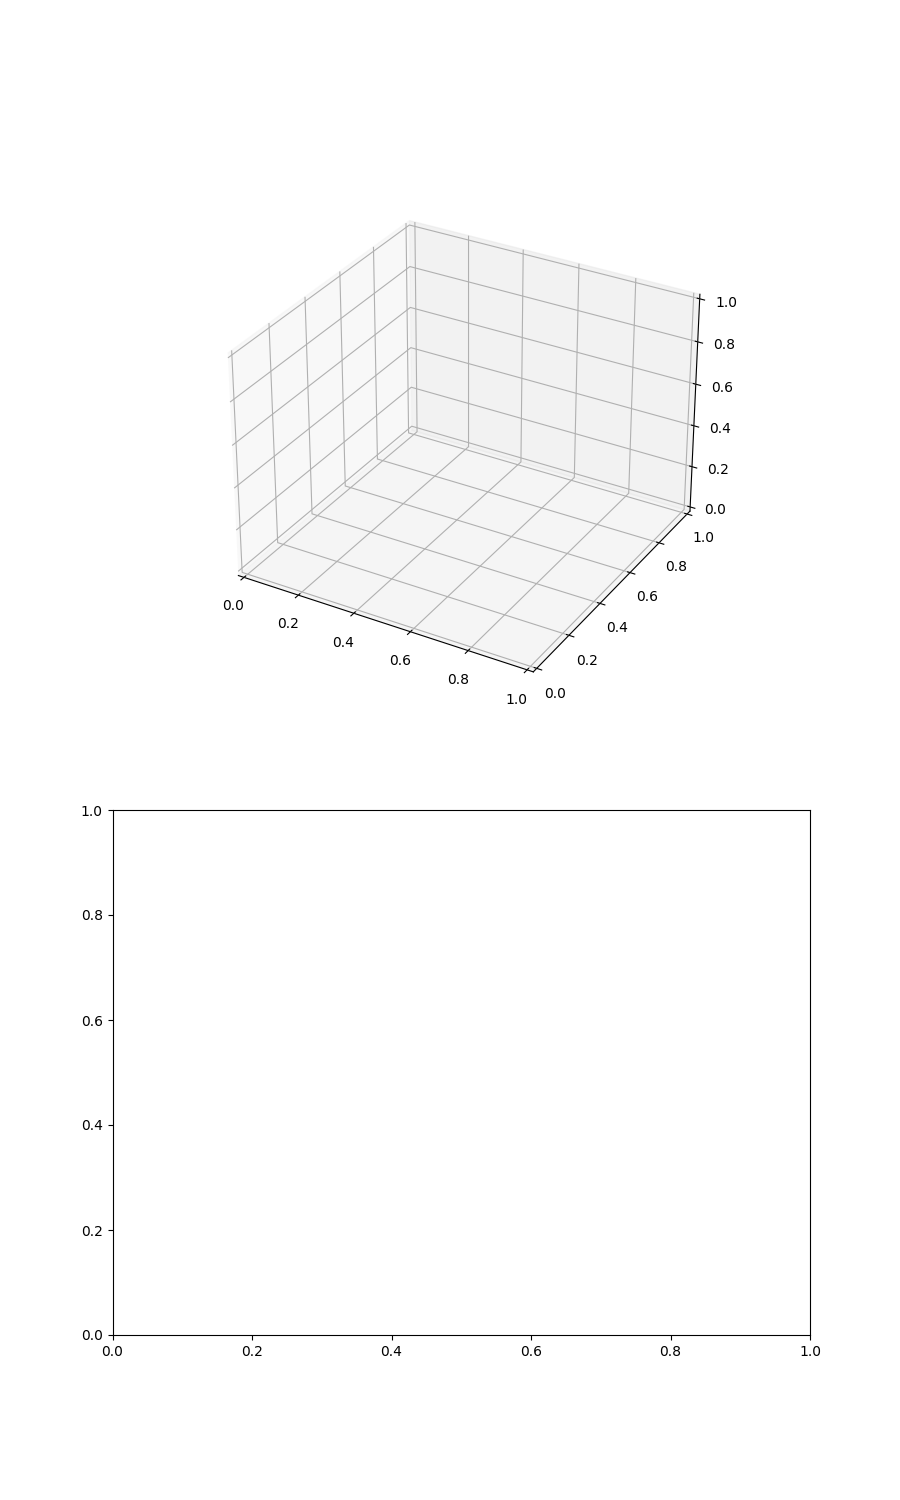

In [2]:
def plot_function(f, fig, ax, zlim=[-10, 10], xy_range=[-10, 10], cmap=cm.gist_ncar, step=0.1, quality=100, bar=True):
    X = np.arange(*xy_range, step)
    Y = np.arange(*xy_range, step)
    X, Y = np.meshgrid(X, Y)
    get_f = lambda i: (f(np.array([X[i, j], Y[i, j]])) for j in range(X.shape[1]))
    a = np.fromiter(chain.from_iterable(get_f(i) for i in range(X.shape[0])), float, X.shape[0]*X.shape[1])
    Z = a.reshape(X.shape)

#     fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cmap, rcount=quality, ccount=quality,
    linewidth=0, antialiased=False, alpha=0.6)
    ax.set_zlim(*zlim) 
    ax.zaxis.set_major_locator(LinearLocator(10)) 
    ax.zaxis.set_major_formatter('{x:.02f}')
    if bar:
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    return fig

def plot_contour(f, fig, ax, xy_range=[-10, 10], step=0.1, cmap=cm.gist_ncar, quality=100, bar=True):
    X = np.arange(*xy_range, step)
    Y = np.arange(*xy_range, step)
    X, Y = np.meshgrid(X, Y)
    get_f = lambda i: (f(np.array([X[i, j], Y[i, j]])) for j in range(X.shape[1]))
    a = np.fromiter(chain.from_iterable(get_f(i) for i in range(X.shape[0])), float, X.shape[0]*X.shape[1])
    Z = a.reshape(X.shape)
    plot = ax.contourf(X, Y, Z, np.arange(Z.min(), Z.max(), step), cmap=cmap)
    if bar:
        fig.colorbar(plot, ax=ax, shrink=0.5, aspect=5)
    return fig

class Animate3D:
    anms = None 
    fig = plt.figure(figsize=(9, 15))
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    ax2 = fig.add_subplot(2, 1, 2)
    counter = 0
    
    def __init__(self, f, x0, xy_range, zlim):
        self.f = f
        self.data = np.array([x0])
        self.plt_3d = lambda bar: plot_function(f, fig=self.fig, ax=self.ax1, zlim=zlim, xy_range=xy_range, cmap=cm.turbo, step=0.1, bar=bar)
        self.contour = lambda bar: plot_contour(f, fig=self.fig, ax=self.ax2, xy_range=xy_range, cmap=cm.turbo, bar=bar)
#         self.point1 = self.ax1.scatter(x0[0], x0[1], self.f(x0), color='r',  s=6, marker='^')
#         self.point2 = self.ax2.scatter(x0[0], x0[1], self.f(x0), color='r', marker='s')
    
    def length(self):
        return len(self.data)
    
    def add(self, x):
        self.data = np.vstack([self.data, [x]])
            
    
    def frame(self, i):
        print(i)
        if self.counter == 0:
            self.counter += 1
            return
        if(i % self.length() == 0):
            self.ax1.clear()
            self.ax2.clear()
            self.plt_3d(True if i == 0 else False)
            self.contour(True if i == 0 else False)
            x0 = self.data[0]
            self.point1 = self.ax1.scatter(x0[0], x0[1], self.f(x0), color='r',  s=6, marker='^')
            self.point2 = self.ax2.scatter(x0[0], x0[1], color='r', marker='s', s=3)
#             self.ax1.view_init(azim=(45 + 90 * np.floor(i / self.length())))
            return
        x1, x2 = self.data[(i-1) % self.length()], self.data[i % self.length()]
        X = np.linspace(x1[0], x2[0], 500)
        Y = np.linspace(x1[1], x2[1], 500)
        Z = [self.f(np.array([x, y])) for x,y in zip(X, Y)]
        self.point1 = self.ax1.scatter(x2[0], x2[1], self.f(x2), color='r', s=6, marker='^')
        self.point1 = self.ax2.scatter(x2[0], x2[1], color='r', s=3, marker='s')
        self.current_line1 = self.ax1.plot(X, Y, Z, color='r', linewidth=1)
        self.current_line2 = self.ax2.plot(X, Y, color='r', linewidth=0.7)
    
    def get_animation(self):
        return pltanimation.FuncAnimation(self.fig, self.frame, frames=self.length(), interval=400, repeat=True)
        

<IPython.core.display.Javascript object>


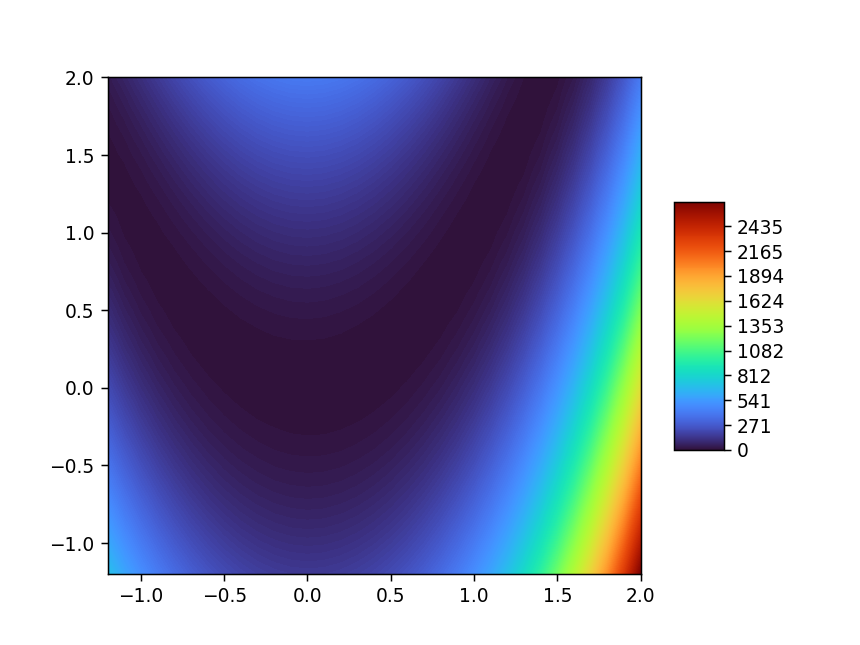

<IPython.core.display.Javascript object>


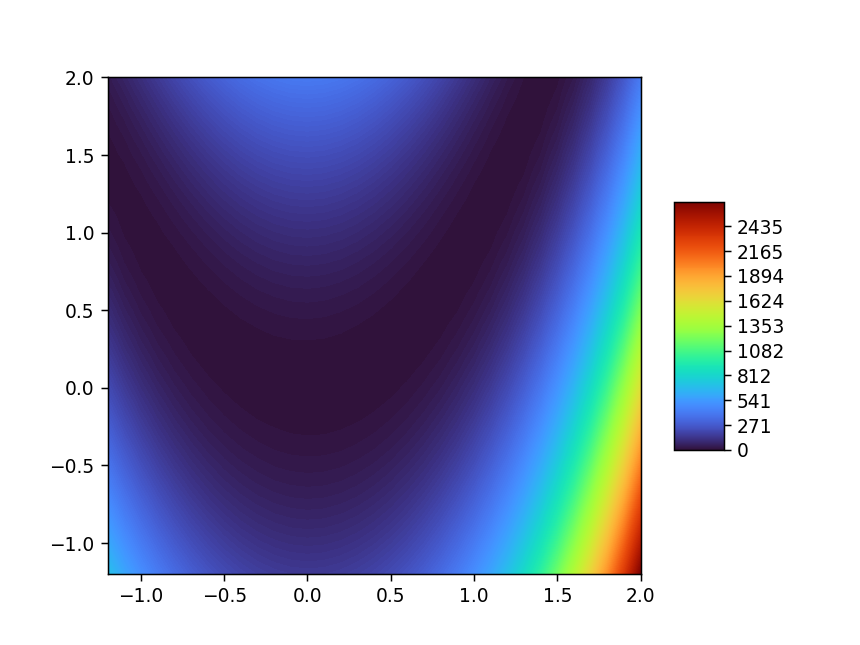

In [9]:
fig, ax = plt.subplots()
b = lambda: plot_contour(rosenbrok, fig, ax, xy_range=[-1.2, 2.1], cmap=cm.turbo)
b()

### Test functions

#### Rosenbrock banana function:
$$
f(x_1, x_2, ..., x_N) = \sum^{N/2}_{i=1}[100(x^2_{2i-1} - x_{2i})^2 + (x_{2i-1} - 1)^2]
$$

In [3]:
rosenbrok = lambda x: (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2 
danilov = lambda x: x[0] + 2*x[1] + 4*m.sqrt(1 + x[0]**2 + x[1]**2)


test_danilov = [
    danilov,
    approx_gradient(danilov, 1e-10),
    np.array([-2, 2]),
    0.001,
    [[-3, 3], [0, 16]]
]

test_rosen = [
    rosenbrok,
    approx_gradient(rosenbrok, np.float64(1e-8)),
    np.array([-1, -1]),
    1e-4,
    [[-1.2, 2.1], [0, 1000]]
]


test_rastrigin = [
    rastrigin,
    approx_gradient(rastrigin, np.float64(1e-8)),
    np.array([2, 1]),
    1e-4
]

test_ackley = [
    ackley,
    approx_gradient(ackley, np.float64(1e-9)),
    np.array([1, 1]),
    1e-4
]

test_sphere = [
    sphere,
    approx_gradient(sphere, np.float64(1e-9)),
    np.array([-3, 3]),
    1e-5,
    [[-3, 3], [0, 10]]
]

test_beale = [
    beale,
    approx_gradient(beale, np.float64(1e-9)),
    np.array([3, 1.5]),
    1e-3,
    [[-0.01, 800], [2.9, 1.6]]
]

test_goldstein = [
    goldstein_price,
    approx_gradient(goldstein_price, np.float64(1e-9)),
    np.array([-1.3, 1]),
    1e-5,
    [[-1.5, 1], [0, 50000]]
]

test_booth = [
    booth,
    approx_gradient(booth, np.float64(1e-8)),
    np.array([30, 50]),
    1e-5
]

test_bukin = [
    bukin,
    approx_gradient(bukin, np.float64(1e-8)),
    np.array([-10.5, 1.5]),
    1e-5
]

test_himmel = [
    himmelblau,
    approx_gradient(himmelblau, np.float64(1e-8)),
    np.array([56, 41]),
    1e-5
]

test_egg = [
    eggholder,
    approx_gradient(eggholder, np.float64(1e-8)),
    np.array([353, -200]),
    1e-7
]

test_cross = [
    cross,
    approx_gradient(cross, np.float64(1e-8)),
    np.array([2, -2]),
    1e-4
]

### Fastest descent method

We will construct relaxational sequence, using this rule:
$$
\vec{x}_{k+1} = \vec{x}_k + \lambda_k\vec{w}_K
$$

Where $\lambda_k$ is found from
$$
\lambda_k = argmin\{\psi_k(\lambda)\} \\
\psi_k(\lambda) = f(\vec{x}_{k-1} + \lambda\vec{w}_k)
$$

Finding minimum of $\psi_k(\lambda)$ is a pretty complex task of one-dimension minimization. But it is guaranteed that $\{|\vec{w}_k|\}$ convergace to 0.

So at start we pick some small $\epsilon$ and continuing procedure while $|\vec{w}_k\| > \epsilon$, than on some N iteration we pick our $x_* = x_N$

In [12]:
def fastest_descent(f, gr, x, epsilon, plot_params):
    anim = Animate3D(f, x, *plot_params)
    n = len(x)
    w = -gr(x) 
    phi = toOneParamFunc(f, x, w)
    anim.add(x)
    l, i = argmin(phi, 0, 1, np.divide(epsilon, 1e4))
    n += i
    k = 1
    print(x, f(x), l, norm(w))
    x = x + l*w
    anim.add(x)
    while(norm(w) > epsilon):
        w = -gr(x) 
        phi = toOneParamFunc(f, x, w)
        l, i = argmin(phi, 0, 1, np.divide(epsilon, 1e4))
        n += i
        k += 1
        print(x, f(x), l, norm(w))
        x = x + l*w
        anim.add(x)
    return f(x), x, k, n, anim

In [13]:
# f1 = lambda x: 6*x[0]**2 - 4*x[0]*x[1] + 3*x[1]**2 + 4*m.sqrt(5)*(x[0] + 2*x[1]) + 22
# f2 = lambda x: (x[0]**2 - x[1])**2 + (x[0] - 1)**2

fmin, xmin, K, N, anim = fastest_descent(*test_sphere)
print(f"""
x minimum: {xmin},
f minimum: {fmin},
number of iterations: {K}
number of one-dimension minimization iterations: {N}
""")

lol = anim.get_animation().save('fastest-descent-method.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


[-3  3] 18 0.5 8.48528137423857
[0. 0.] 0.0 0.0 1.4142135623730951e-09

x minimum: [0. 0.],
f minimum: 0.0,
number of iterations: 2
number of one-dimension minimization iterations: 4

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


### Conjugate gradient method

#### Problem 

$$
f(\vec{x}) = \frac{1}{2}(Q\vec{x}, \vec{x}) + (\vec{c}, \vec{x}) \rightarrow min
$$

$Q$ is positive determined n-dimsensional matrix, $c \in \mathbb{R}$ - constant

This function has single point of minimum $x_* = -Q^{-1}\vec{c}$

To find the inverted matrix $Q^{-1}$ we can use
$$
Q^{-1} = \sum^n_{i=1}\frac{p^i(p^i)^T}{(Qp^i, p^i)}
$$
Where $p^i \in \mathbb{R}$ is conjugate vector of matrix $Q$

But constructing a system of conjugate vectors is a pretty complex problem.

So we do another way, let's construct system of conjugate vectors on every iteration

$\vec{x}_0$ is a starting point, antrigradient in this point is $\vec{w}_1 = -Qx_0 - c$ and let's choose $\vec{p}_1 = \vec{w}$

Using $\vec{x}_k = \vec{x}_{k-1} + \lambda_k\vec{w}_k$

We can find that 
$$\lambda_1 = \frac{|\vec{w}_1|^2}{(Q\vec{w}_1, \vec{w}_1)} = \frac{|\vec{p}_1|^2}{(Q\vec{p}_1, \vec{p}_1)}$$
(from minimization of quadratic function)

And so $x_1 = x_0 + \lambda_1\vec{p}_1$

On second iteration (k = 2) we evaluate antigradient $\vec{w}_2 = -Q\vec{x_1} - c$

Let's assume, that
$$\vec{p}_2 = \gamma_1\vec{p}_1 + \vec{w}_2$$

If we product scalarly this equation on $Q\vec{p}_1 \not = 0$ and demand that $\vec{p}_1, \vec{p}_2$ are conjugate (ortogonal) over the matrix $Q$ ($(Q\vec{p}_1, \vec{p_2}) = 0$), we can find $\gamma_1$
$$\gamma_1 = -\frac{(Q\vec{p}_1, \vec{w}_2)}{(Q\vec{p}_1, \vec{p}_1)}$$

Contniuing constructing this system of conjugate vectors, we can say, that on every k iteration we have system of equations:
$$
\begin{cases}
    p_{k+1} = \gamma\vec{p_k} + \vec{w}_{k+1} \\
    \gamma_k = - \frac{(Q\vec{p}_k, \vec{w}_{k+1})}{(Q\vec{p}_k, \vec{p}_k)} \\
    \vec{w}_{k+1} = \vec{w}_k = \lambda_kQ\vec{p}_k \\
    (Q\vec{p}_{k+1}, \vec{p}_i) = 0 \\
    (\vec{w}_{k+1}, \vec{w}_i) = 0, i = \overline{1, k} \\
\end{cases} \\
\mbox{also } \\
\lambda_k = \frac{(\vec{w}_k, \vec{p}_k)}{(Q\vec{p}_k, \vec{p}_k)},\\
\vec{x}_k = \vec{x_1} + \lambda_k\vec{p}_k
$$

With n steps we can find all $\vec{p}_k$ conjugate vectors and evaluate our minimum $x_* = -Q^{-1}\vec{c}$

To use this method in our problems (non-quadratic function optimization, we need to remove matrix $Q$ from system of equations

We can do this, by if on every iteration by doing minimization process:
$$
\psi_k(\lambda) = f(x_{k-1} + \lambda)
$$

In fundament of constructing conjuguate directions $\vec{p}_{k+1} = \gamma_k\vec{p}_k + \vec{w}_{k+1}$ we assume, that $(\vec{w}_{k+1}, \vec{w}_i) = 0$

Using this we can show that:
$$
\begin{cases}
    (Q\vec{p}_k, \vec{w}_{k+1}) = - \frac{1}{\lambda_k}|\vec{w}_{k+1}|^2 \\
    (Q\vec{p}_k, \vec{p}_{k}) = \frac{1}{\lambda_k}(\vec{w}_k, \vec{p}_k)
\end{cases} \\
\mbox{so from our system of equations we can evaluate $\gamma$ using one of theese formulas: } \\
\gamma_k = \frac{|\vec{w}_{k+1}|^2}{|\vec{w}_k|^2} \\
\gamma_k = \frac{(\vec{w}_{k+1} - \vec{w}_k, \vec{w}_{k+1})}{|\vec{w}_k|^2} \\
\mbox{also if function twice differentiable, we can use Hessian instead of matrix Q:} \\
\gamma_k = - \frac{(H(\vec{x}_k)\vec{p}_k, \vec{w}_{k+1})}{(H(\vec{x}_k)\vec{p}_k, \vec{p}_k)} \\
$$

This method is called ***conjaguate gradients method***

Also as every $\gamma_k$ is different and we need to minimize $\psi_k(\lambda)$ this turns us to inevitably errors, to minimize errors, we need to do **restarts** (set $\gamma_k = 0$). It is common to restart every $n$ times, where $n$ is our dimension number. Also, with non-quadratic functions our procedure of optimization in general don't take $n$ steps, so we choose our $\epsilon$ and iterate through $\{\vec{x}_k\}$ till our |$\vec{w}_{k+1|} < \epsilon$, and then $x_{k-1} \approx x_*$ 



In [4]:
def conjugate_gradient(f, gr, x, epsilon, plot_params):
    anim = Animate3D(f, x, *plot_params)
    w = -gr(x) 
    p = w
    phi = toOneParamFunc(f, x, p)
    l, i = argmin(phi, 0, 1, np.divide(epsilon, 1e3))
    n = i
    print(x, f(x), l, p)
    x = x + l*p
    anim.add(x)
    w_2 = -gr(x)
    k = 1
    while norm(w_2) > epsilon:
        gamma = np.divide(np.dot(w_2 - w, w_2), np.power(norm(w), 2))
        p = gamma*p + w_2
        phi = toOneParamFunc(f, x, p)
        l, i = argmin(phi, 0, 1, np.divide(epsilon, 1e3)) 
        n += i
        print(x, f(x), l, p)
        x = x + l*p
        anim.add(x)
        w = w_2
        w_2 = -gr(x)
        k += 1
    return f(x), x, k, n, anim
        

In [ ]:
fmin, xmin, K, N, anim = conjugate_gradient(*test_goldstein)
print(f"""
x minimum: {xmin},
f minimum: {fmin},
number of iterations: {K}
number of one-dimension minimization iterations: {N}
""")
kek = anim.get_animation().save('conjugate-method.gif')

MovieWriter ffmpeg unavailable; using Pillow instead.


[-1.3  1. ] 79435.46640543999 1.9732595220485927e-06 [ -64245.14336264 -302642.8789484 ]
[-1.42677234  0.40280706] 2262.4610931783973 1.2365310754370681e-05 [ 7389.87084745 -1759.34978459]
[-1.33539429  0.38105215] 1946.9827754437108 5.49664910304928e-05 [ 13072.01916072 -14283.92784485]
[-0.61687127 -0.40408524] 30.488453912783058 0.0002161263978857636 [112.50900737 -27.18112976]
[-0.5925551 -0.4099598] 30.04150159287167 0.0007711572610455207 [-9.58669046 12.90033584]
[-0.59994795 -0.40001161] 30.000002113632892 0.0002871976222053811 [-0.18550396  0.04628689]
Starting Fibbonaci
[-0.60000122 -0.39999832] 30.0000000012346 0.0007174550680637466 [ 0.00169168 -0.00232348]
[-0.60000001 -0.39999999] 30.000000000000075 2.743491364752351e-05 [-3.17005315e-05  7.58497872e-06]
Starting Fibbonaci
[-0.60000001 -0.39999999] 30.00000000000008 0.00041446273630719576 [ 3.49184878e-06 -1.58964052e-05]
Starting Fibbonaci
[-0.60000001 -0.39999999] 30.000000000000036 0.00043686000109154674 [ 1.41499904e-0

In [ ]:
eggholder(np.array([522.16052378, 413.31579314]))
eggholder(np.array([689.54388631, 704.10898454]))
eggholder(np.array([951.81007835, -643.80954877]))
eggholder(np.array([2176.39443531, -2025.93193537